# Partie Football

Nous avons à disposition 5 datasets : 'club.csv', 'match.csv', 'match_event.csv', 'player.csv', 'referee.csv'. Nous allons principalement utilisé les datasets 'match.csv' et 'match_event' ces fichiers contiennnent les informations utiles à notre projet, les autres viendront les compléter dans leur description. L'objectif sera de battre les bookmakers dans leurs prédictions.

Dans cette partie, nous allons étudier le fichier "match.csv" grâce à une datavisualisation des données.
Ce dataset représente les matchs qui ont lieu durant la saison 2017-2018 pour les 5 championnats majeurs européens en première division (Ligue 1, Serie A, Bundesliga, Premier Ligue, Liga) en prenant en compte uniquement ses matchs avec un vainqueur. **Il est important de préciser que ce dataset ne comporte pas de match nul et les côtes des Bookmakers.** Nous allons donc concentrer les prédictions sur les victoires et défaites par équipe. Ce dataset nous informe pour chaque match le lieu, la date, les équipes qui s’affrontent, et l’arbitre de chaque rencontre. Nous disposons également du club qui reçoit à domicile et celui qui est en déplacement, Le score de la partie ainsi que le nom du vainqueur de chaque rencontre.


# Chapitre 1:  Nettoyage et Exploration du dataset <a class="anchor" id="chapter1"></a>

Le dataset ne contient pas de valeurs manquantes informatiquement mais de nombreux stades de football ne sont pas référencés, on choisira donc de supprimer cette colonne. De plus, on connaît le club jouant à domicile donc nous savons qu’il joue dans son stade et le nom du stade est alors connu intrinsèquement. Nous allons vérifier que les noms d'équipes soient les mêmes dans chaques colonne.
Enfin, nous créerons de nouvelles variables utile à notre étude.


In [1]:
#Importation des packages et fichiers utiles à l'étude
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

#Instanciation des dataframes
club=pd.read_csv('club.csv')
mat=pd.read_excel('match.xlsx')
match_event=pd.read_csv('match_event.csv')
df5 = pd.read_csv('referee.csv')

In [2]:
#Partie néttoyage des données
dom=mat

#Suppression de la colonne où figure les stades
dom = dom.drop('venue', axis=1)

#Remplacement du noms des arbitres grâce à la methode des dictionnaires
dico1 = {}
dico1['indices'] = df5.index
dico1['arbitres'] = df5.lastname
dom.referee_id = dom.referee_id.replace(dico1['indices'],dico1['arbitres'])

#On remplace le nom des clubs 
dom = dom.replace('Angers','Angers SCO')
dom = dom.replace('Saint','Saint-étienne')

Affichage du dataset obtenu:

In [3]:
dom.head()

,id,dateutc,competition,season,home_club,away_club,winner,goal_by_home_club,goal_by_away_club,referee_id
0,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi
1,1,2018-05-20 18:45:00,Italian first division,2018,Sassuolo,Roma,Roma,0,1,Abbattista
2,2,2018-05-20 16:00:00,Italian first division,2018,Cagliari,Atalanta,Cagliari,1,0,Massa
3,3,2018-05-20 16:00:00,Italian first division,2018,Chievo,Benevento,Chievo,1,0,Pasqua
4,4,2018-05-20 16:00:00,Italian first division,2018,Udinese,Bologna,Udinese,1,0,Gavillucci


## 1.1 Nombre de victoire par équipe <a class="anchor" id="section_1_1"></a>

Basons-nous sur le championnat de ligue 1.

In [4]:
#Création de dataframes par championnat
ligue_1 = dom[dom.competition == 'French first division']

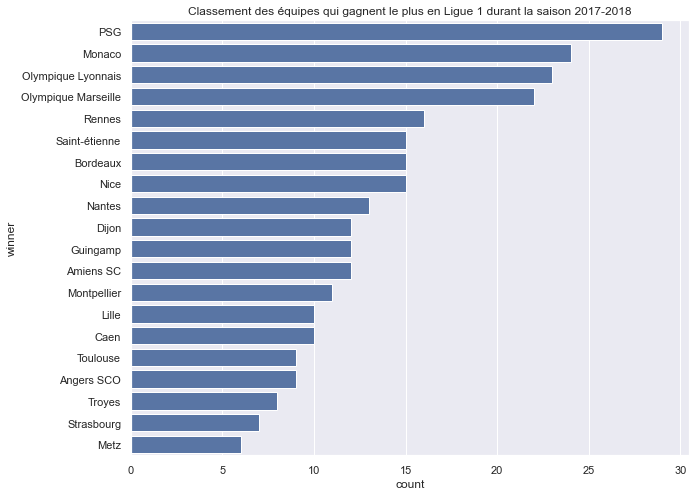

In [5]:
#Partie graphique à partir de la bibliothèque Seaborn
sns.set()
plt.figure(figsize=(10,8))
sns.countplot(y='winner',order = ligue_1['winner'].value_counts().index,data=ligue_1,color='b')
plt.title('Classement des équipes qui gagnent le plus en Ligue 1 durant la saison 2017-2018');

Nous constatons que certains clubs ont plus de victoires que d’autres. On s'aperçoit d’une décroissance linéaire. Nous allons donc faire un test régression linéaire sur nos données pour savoir si elles suivent bien une droite.  

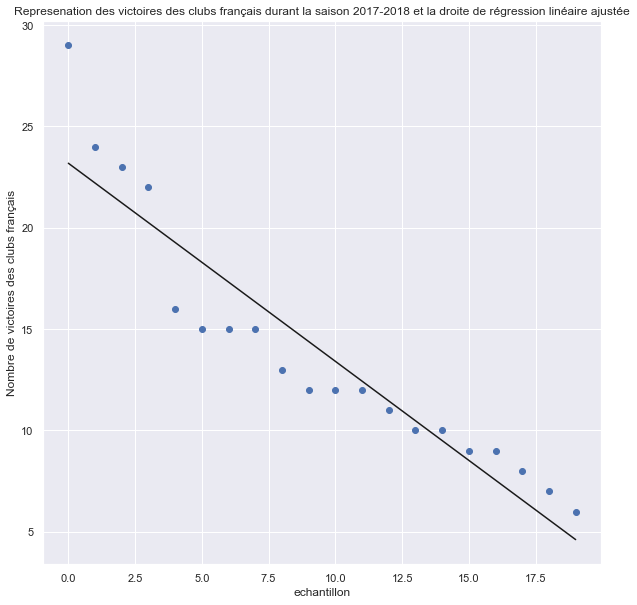

In [6]:
#Partie régression linéaire à partir d'un polynome de degré 1 (une droite)

#Création de tableau avec le nombre de victoires par championnat
x1 = range(0,20)
tfr=[]
fr = ligue_1['winner'].value_counts()

for i in range(len(ligue_1['winner'].value_counts())):
    tfr.append(fr[i])
    
c,d = np.polyfit(x1,tfr, 1)

plt.figure(figsize = (10,10))
plt.scatter(x1,fr)
plt.plot(x1,c*x1+d, color='k');
plt.title('Represenation des victoires des clubs français durant la saison 2017-2018 et la droite de régression linéaire ajustée')
plt.xlabel('echantillon')
plt.ylabel('Nombre de victoires des clubs français');

On constate en effet d’après les tests effectués que les victoires des différents clubs dans le chapionnat de france suivent une loi linéaire car la droite de régression est raisonnablement ajustée hormis quelques points.
Il est maintenant nécessaire d’étudier la différence entre les victoires à domicile et à l’extérieur.


## 1-2. Importance extérieur VS domicile <a class="anchor" id="section_1_2"></a>

Représentation du nombre de victoires à domicile et à l'exterieur par équipe dans chaque championnat.


In [7]:
#Création de colonnes victoires à domicile et extérieure
dom.loc[dom['home_club'] == dom['winner'], 'dom_game'] = 'Victoire'  
dom.loc[dom['home_club'] != dom['winner'], 'dom_game'] = 'Défaite'
dom.loc[dom['away_club'] == dom['winner'], 'away_game'] = 'Victoire'  
dom.loc[dom['away_club'] != dom['winner'], 'away_game'] = 'Défaite' 

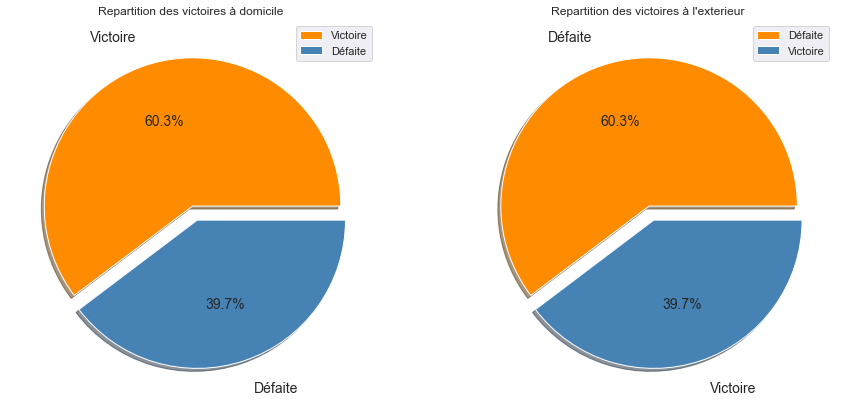

In [8]:
#La repartitions des victoires à domicile et exterieur.
a = dom.dom_game.value_counts(normalize = True)
b = dom.away_game.value_counts(normalize = True)

plt.figure(figsize = (15,15))
plt.subplot(221)
plt.pie(x=a, labels = a.index, autopct= lambda x: str(round(x,2))+ '%',
       shadow = True, labeldistance = 1.2, explode = [0,0.1],
       textprops = {'fontsize': 14},
       colors = ['darkorange', 'steelblue'])
plt.legend()
plt.title("Repartition des victoires à domicile ");

plt.subplot(222)
plt.pie(x=b, labels = b.index, autopct= lambda x: str(round(x,2))+ '%',
       shadow = True, labeldistance = 1.2, explode = [0,0.1],
       textprops = {'fontsize': 14},
       colors = ['darkorange', 'steelblue'])
plt.legend()
plt.title("Repartition des victoires à l'exterieur ");

In [9]:
dom.dom_game = dom.dom_game.replace({'Défaite': 0, 'Victoire': 1})
dom.away_game = dom.away_game.replace({'Défaite': 0, 'Victoire': 1})

Ces graphiques nous montrent que jouer à domicile ou à l’extérieur peut avoir une influence sur le nombre de victoires. 60,3% des matchs à domicile sont gagnés contre 39,7% à l'extérieur.

Nous allons créer un tableau récapitulatif du nombre de victoires, de buts par équipe.

In [10]:
#Classement du championnat français
aa = dom.home_club.value_counts()
bb = dom.away_club.value_counts()
cc = aa+bb

#Séparation par championnat 
ita = dom[(dom.competition == 'Italian first division')]
esp = dom[(dom.competition == 'Spanish first division')]
fra = dom[(dom.competition == 'French first division')]
ang = dom[(dom.competition == 'English first division')]
alle= dom[(dom.competition == 'German first division')]

a = fra.groupby('home_club').agg({'goal_by_home_club' :'sum'})
b = fra.groupby('away_club').agg({'goal_by_away_club' :'sum'})
a = a.rename(columns={'goal_by_home_club': 'But à domicile'})
b = b.rename(columns={'goal_by_away_club': 'But à l exterieur'})
df1 = pd.concat([a,b], axis = 1)
df1['Total de Buts'] = df1['But à domicile']+df1['But à l exterieur']
df1['Moyenne'] = (df1['Total de Buts']/cc).round(2)
df1['NB victoires'] = dom.winner.value_counts()
df1['NB victoires dom'] = dom.groupby('home_club').agg({'dom_game' :'sum'})
df1['NB victoires ext'] = dom.groupby('away_club').agg({'away_game' :'sum'})
df1['nom'] = df1.index
df1 = df1.sort_values(by ='NB victoires dom',  ascending=False)
df1

,But à domicile,But à l exterieur,Total de Buts,Moyenne,NB victoires,NB victoires dom,NB victoires ext,nom
PSG,68,33,101,3.16,29,17,12,PSG
Monaco,44,31,75,2.50,24,15,9,Monaco
Olympique Marseille,38,25,63,2.33,22,12,10,Olympique Marseille
Olympique Lyonnais,30,43,73,2.52,23,12,11,Olympique Lyonnais
Nice,25,18,43,1.48,15,10,5,Nice
Dijon,30,8,38,1.41,12,10,2,Dijon
Bordeaux,25,20,45,1.50,15,9,6,Bordeaux
Amiens SC,21,8,29,1.00,12,8,4,Amiens SC
Saint-étienne,21,13,34,1.21,15,8,7,Saint-étienne
Rennes,16,21,37,1.32,16,8,8,Rennes


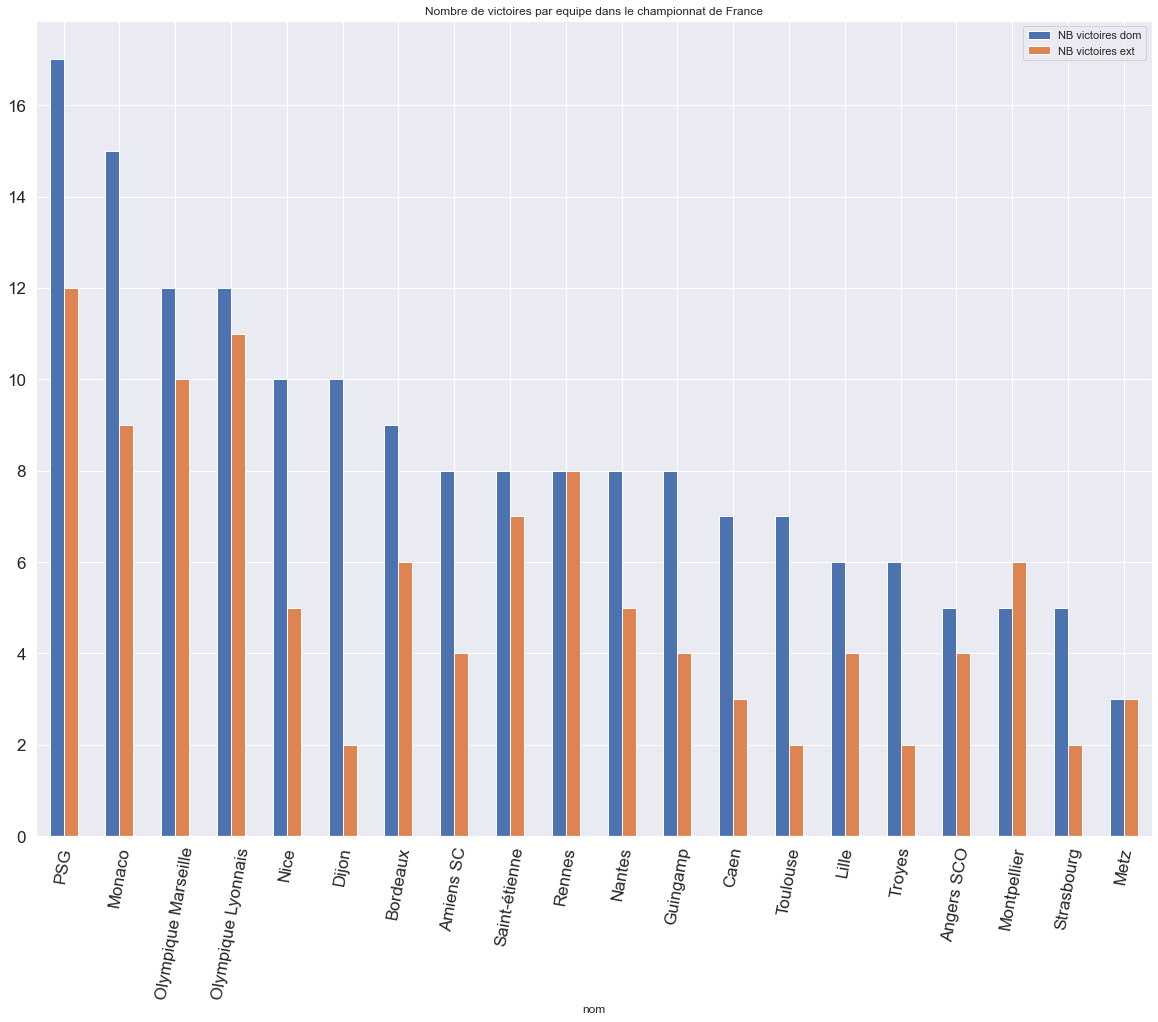

In [11]:
#Représentation visuelle pour chaque équipe
df1.plot.bar(x = 'nom', y=['NB victoires dom', 'NB victoires ext'], stacked=False, rot = 80, fontsize = 17,
           figsize = (20,15),title = "Nombre de victoires par equipe dans le championnat de France");

## 1-3. Tests statistiques pour les victoires <a class="anchor" id="section_1_3"></a>

Réalisation d’un test Chi2 des victoires par championnat à domicile et à l'extérieur.

In [12]:
from scipy.stats import chi2_contingency
df = pd.crosstab(ita.home_club, ita.dom_game)
dp = pd.crosstab(ita.away_club, ita.away_game)

#Italie exterieur
resultats_test = chi2_contingency(dp)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]


def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dp)[0]
    k = dp.shape[0]
    r = dp.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

itae = pd.DataFrame((statistique, p_valeur, degre_liberte, V_Cramer(dp,ita.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte', 'V_Cramer'], columns = ['Italie exterieur'])

#Italie domicile
resultats_test = chi2_contingency(df)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]


def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(df)[0]
    k = df.shape[0]
    r = df.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

itad = pd.DataFrame((statistique, p_valeur, degre_liberte,V_Cramer(df,ita.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte', 'V_Cramer'], columns = ['Italie domicile'])

#France Exterieur
dff = pd.crosstab(fra.home_club, fra.dom_game)
dpf = pd.crosstab(fra.away_club, fra.away_game)

resultats_test = chi2_contingency(dpf)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dpf)[0]
    k = dpf.shape[0]
    r = dpf.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

frae = pd.DataFrame((statistique, p_valeur, degre_liberte,V_Cramer(dpf,fra.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte','V_Cramer'], columns = ['France exterieur'])

#France domicile
resultats_test = chi2_contingency(dff)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]


def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dff)[0]
    k = dff.shape[0]
    r = dff.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

frad = pd.DataFrame((statistique, p_valeur, degre_liberte,V_Cramer(dff,fra.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte','V_Cramer'], columns = ['France domicile'])

#Angleterre exterieur
dfa = pd.crosstab(ang.home_club, ang.dom_game)
dpa = pd.crosstab(ang.away_club, ang.away_game)

resultats_test = chi2_contingency(dpa)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dpa)[0]
    k = dpa.shape[0]
    r = dpa.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))


ange = pd.DataFrame((statistique, p_valeur, degre_liberte,V_Cramer(dpa,ang.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte','V_Cramer'], columns = ['Angleterre exterieur'])

#Angleterre domicile
resultats_test = chi2_contingency(dfa)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dfa)[0]
    k = dfa.shape[0]
    r = dfa.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

angd = pd.DataFrame((statistique, p_valeur, degre_liberte,V_Cramer(dfa,ang.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte','V_Cramer'], columns = ['Angleterre dommicile'])


#Espagne exterieur
dfe = pd.crosstab(esp.home_club, esp.dom_game)
dpe = pd.crosstab(esp.away_club, esp.away_game)
from scipy.stats import chi2_contingency

resultats_test = chi2_contingency(dpe)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dpe)[0]
    k = dpe.shape[0]
    r = dpe.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

espe = pd.DataFrame((statistique, p_valeur, degre_liberte, V_Cramer(dpe,esp.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte', 'V_Cramer'], columns = ['Espagne exterieur'])

#Espagne domicile
resultats_test = chi2_contingency(dfe)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dfe)[0]
    k = dfe.shape[0]
    r = dfe.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

espd =  pd.DataFrame((statistique, p_valeur, degre_liberte, V_Cramer(dfe,esp.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte', 'V_Cramer'], columns = ['Espagne domicile'])

#Allemagne exterieur
dfal = pd.crosstab(alle.home_club, alle.dom_game)
dpal = pd.crosstab(alle.away_club, alle.away_game)

resultats_test = chi2_contingency(dpal)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dpal)[0]
    k = dpal.shape[0]
    r = dpal.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))


allee = pd.DataFrame((statistique, p_valeur, degre_liberte, V_Cramer(dpal,alle.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte', 'V_Cramer'], columns = ['Allemagne exterieur'])

#Allemagne domicile
from scipy.stats import chi2_contingency

resultats_test = chi2_contingency(dfal)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

def V_Cramer (table,N):
    stat_chi2 = chi2_contingency(dfal)[0]
    k = dfal.shape[0]
    r = dfal.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

alled = pd.DataFrame((statistique, p_valeur, degre_liberte, V_Cramer(dfal,alle.shape[0])), 
             index =['statistique', 'p_valeur','degre_liberte', 'V_Cramer'], columns = ['Allemagne domicile'])

In [13]:
#Tableau final exterieur
pd.concat([frae, itae,ange,espe,allee ], axis = 1)

,France exterieur,Italie exterieur,Angleterre exterieur,Espagne exterieur,Allemagne exterieur
statistique,58.764484,8.991917e+01,63.545905,56.844890,37.159994
p_valeur,0.000006,3.428369e-11,0.000001,0.000012,0.003201
degre_liberte,19.000000,1.900000e+01,19.000000,19.000000,17.000000
V_Cramer,0.378561,4.892624e-01,0.415182,0.362815,0.304211


In [14]:
#Tableau final domicile
pd.concat([frad, itad, angd,espd,alled ], axis = 1)

,France domicile,Italie domicile,Angleterre dommicile,Espagne domicile,Allemagne domicile
statistique,42.623951,45.897216,49.749373,49.647771,29.682914
p_valeur,0.001459,0.000513,0.000143,0.000148,0.028725
degre_liberte,19.000000,19.000000,19.000000,19.000000,17.000000
V_Cramer,0.291614,0.301087,0.344819,0.326431,0.241012


Interprétation: Les P-valeurs sont inférieures à 5% pour chaque championnat ce qui signifie qu’il y a une corrélation entre le fait de jouer à domicile ou à l'extérieur et la victoire d’une équipe. Le V de Cramer indique d’une part que la corrélation est plus ou moins forte d’un championnat à un autre et d’autre part, qu’elle est plus importante lorsqu'une équipe joue à l'extérieur qu'à domicile.

## 1-4. Nombre de buts total et moyenne de buts par championnat <a class="anchor" id="section_1_4"></a>


In [15]:
#Création de deux colonnes 'total_buts' et'diff_buts'
dom['total_buts'] = dom.goal_by_home_club + dom.goal_by_away_club
dom['diff_buts'] = np.abs(dom.goal_by_home_club - dom.goal_by_away_club)

In [16]:
#Création d'un dataframe avec la somme de buts et la moyenne de buts par compétition
goal_by_champ = dom.groupby('competition', as_index=False).agg({'total_buts':['sum','mean']})

In [17]:
goal_by_champ

competition total_buts          
                                 sum      mean
0  English first division        775  2.992278
1   French first division        800  2.877698
2   German first division        654  3.000000
3  Italian first division        875  2.946128
4  Spanish first division        832  2.888889

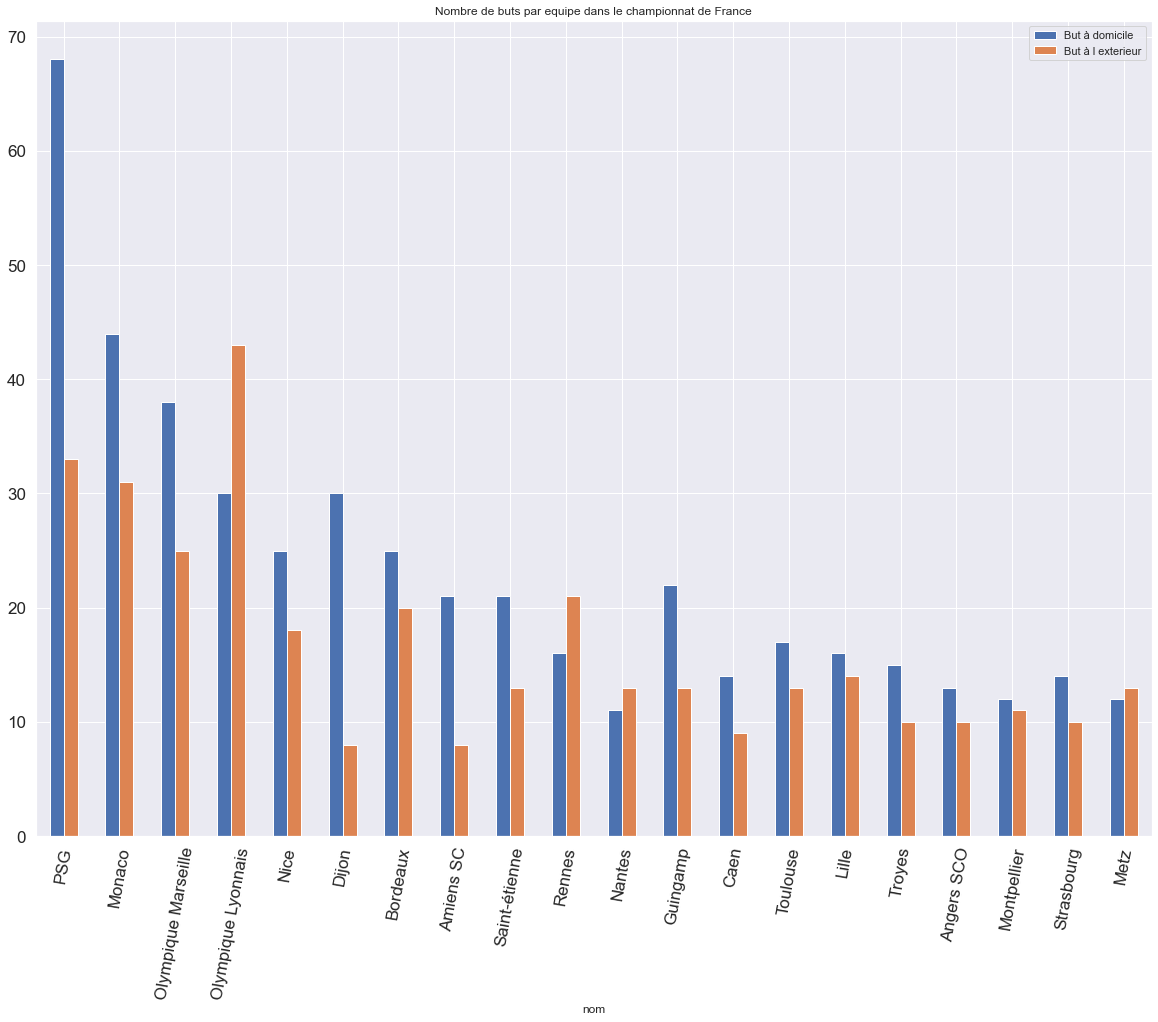

In [18]:
#Répartition du nombre de buts par équipe
df1.plot.bar(x = 'nom', y=['But à domicile','But à l exterieur'], stacked=False, rot = 80, fontsize = 17,
           figsize = (20,15), title = "Nombre de buts par equipe dans le championnat de France");

Ces graphiques nous montrent qu’il y a beaucoup plus de buts marqués à domicile qu’à l'extérieur pour la plupart des équipes. On se pose la question si cela à une influence sur la victoire ou la défaite.

## 1-5. Tests statistiques pour les buts <a class="anchor" id="section_1_5"></a>

Réalisation d’un test ANOVA pour définir si le nombre de but marqués à domicile a une influence sur la victoire ou la défaite:


In [19]:
#Test ANOVA des buts à domicile
import statsmodels.api 

result = statsmodels.formula.api.ols('goal_by_home_club  ~ dom_game', data = dom).fit()
t1 = statsmodels.api.stats.anova_lm(result)
t1

#la p-value (PR(>F)) est inférieur à 5% donc on rejette 
#l'hypothèse H0 selon laquelle dom_game et goal_by_home_club sont indépendants.

,df,sum_sq,mean_sq,F,PR(>F)
dom_game,1.0,1175.846879,1175.846879,1019.860339,8.030479e-167
Residual,1338.0,1542.645658,1.152949,NaN,NaN


In [20]:
#Test ANOVA des buts à l'extérieur
result = statsmodels.formula.api.ols('goal_by_away_club  ~ away_game', data = dom).fit()
t2 = statsmodels.api.stats.anova_lm(result)
t2

#la p-value (PR(>F)) est inférieur à 5% donc on rejette 
#l'hypothèse H0 selon laquelle dom_game et goal_by_home_club sont indépendants.

,df,sum_sq,mean_sq,F,PR(>F)
away_game,1.0,1021.770047,1021.770047,1311.579845,9.654085e-201
Residual,1338.0,1042.352341,0.779038,NaN,NaN


Nous remarquons l'importance de jouer à domicile ou à l'extérieur pour les victoires et les buts. En effet, jouer un match à domicile donne 60% de chance de gagner et marquer plus de buts qu'à l'extérieur. Ce constat nous permet de voir l'importance de ces variables pour la partie Machine Learning.

## 1-6. Etude des corrélations entre les variables <a class="anchor" id="section_1_6"></a>

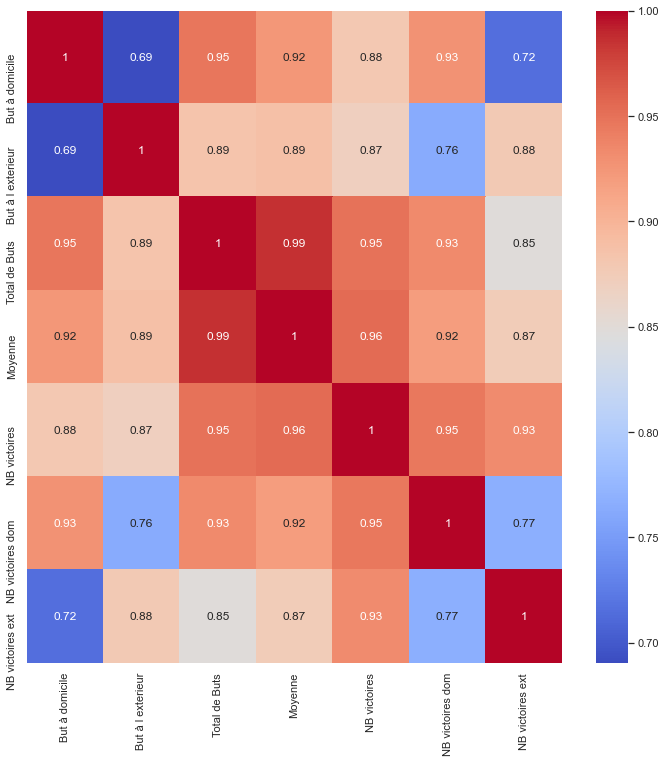

In [21]:
#Création du tableau de corrélation
df = df1
cor = df.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(cor, annot = True, ax = ax, cmap = "coolwarm");

On remarque que de nombreuses vraiables sont corrélées entre elles. Par exemple, le nombre de buts à domicile et le nombre de victoires à domicile est corrélé à 0.93, ce qui est logique vu le constat précédent. Nous allons donc étudier la linéarité à l'aide d'une regression linéaire simple.


In [22]:
#Création des vecteurs vic et but contenant respectivement la variable des victoires à domicile et les valeurs prises par la variable des buts à domicile.
vic = df['NB victoires dom']
but = df[['But à domicile']]

In [23]:
#Instanciation l'origine et la pente de la droite
slr = LinearRegression().fit(but,vic)
print("l'intercept est: ",slr.intercept_)
print("le coeficient est: ",slr.coef_)

l'intercept est:  3.060473269062224
le coeficient est:  [0.23230719]


In [24]:
#Affichage du score moyen sur les échantillons de test
cross_validate(slr,  but, vic, return_train_score=True, cv=4)['test_score'].mean()

-1.438848610252244

In [25]:
#Calcul des valeurs ajustées et des residus
pred_vic= slr.predict(but)
residus = pred_vic - vic
residus.describe()

count    2.000000e+01
mean    -1.776357e-16
std      1.295885e+00
min     -2.384148e+00
25%     -7.983814e-01
50%     -2.569018e-02
75%      7.950811e-01
max      2.848160e+00
Name: NB victoires dom, dtype: float64

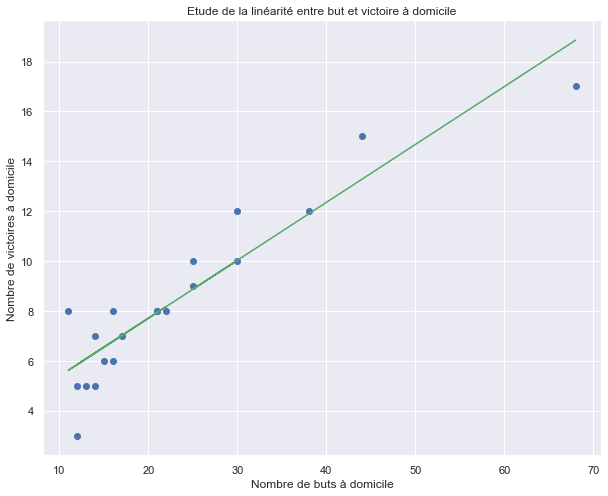

In [26]:
#Affichage du nuage de points avec une droite de regression
plt.figure(figsize= (10,8))
plt.scatter(df['But à domicile'],df['NB victoires dom'])
plt.plot(but,pred_vic, color = 'g')
plt.xlabel('Nombre de buts à domicile')
plt.ylabel('Nombre de victoires à domicile')
plt.title('Etude de la linéarité entre but et victoire à domicile');

In [27]:
#Affichage de la F-statistique et la a p-value associé au test 
from sklearn.feature_selection import f_regression
print('F-score:', f_regression(but, vic)[0], 'p-value :', f_regression(but, vic)[1])

F-score: [111.15956635] p-value : [3.93299521e-09]


Nous pouvons constater qu'en effet que la majorité des points se situent sur la droite de régression ou proche de celle-ci. On en déduit la linéarité entre le nombre de buts à domicile et les victoires à domicile.  

In [ ]:
# Chapitre 2 : Machine Learning <a class="anchor" id="chapter2"></a>

## 2-1. Exploration d'algorithmes <a class="anchor" id="section_2_2"></a>

### Présentation du dataset match_event

Ce dataset représente le déroulement des matchs dans leur globalité. En effet, il  répertorie l'ensemble des occasions qui ont lieu dans un match de football durant la saison 2017-2018 pour les championnats européens. Il permet alors de suivre le fil de la rencontre en fonction de ce qu'il se passe sur le terrain. Une action est caractérisée par le joueur à l'instant où celle-ci se déroule. Les événements de la rencontre (colonne 'eventname') sont catégorisés selon son type (duel, passe, tir, autres actions sur la balle, coup-franc, tentative sauvée...). Ensuite nous avons colonne 'action' qui decoule de 'eventname' pour apporter plus de précisions sur ces occasions comme par exemple : course, passe de la tête, penalty, passe courte, passe longue. La réussite de ces occasions est dans la colonne 'is_success'.

In [28]:
match_event.head()

,id,club_id,match_id,players_id,matchperiod,eventsec,eventname,action,modifier,x_begin,y_begin,x_end,y_end,is_success
0,26588,81,364,178,1H,2026.197574,Others on the ball,Touch,opportunity,97,58,95.0,68.0,NaN
1,67599,57,339,1838,1H,387.095298,Others on the ball,Touch,opportunity,88,32,91.0,49.0,NaN
2,106637,47,319,1572,2H,2364.713900,Others on the ball,Touch,opportunity,92,44,87.0,0.0,NaN
3,142338,34,295,1486,2H,2092.651843,Others on the ball,Touch,opportunity,94,69,92.0,70.0,NaN
4,209035,63,253,1261,2H,1451.561531,Others on the ball,Touch,opportunity,92,58,93.0,57.0,NaN


### Préparation du dataset pour la classification 

In [29]:
#On filtre sur les évènements où les actions ont été réalisé avec succès.
match_event = match_event[match_event.is_success == 't']

In [30]:
#Fusion des match et match_event sir l'id du match 
dom = dom.rename(columns={"id": "match_id"})
concat = pd.merge(dom, match_event, how = 'inner',on =  'match_id')
concat.head()

,match_id,dateutc,competition,season,home_club,away_club,winner,goal_by_home_club,goal_by_away_club,referee_id,...,matchperiod,eventsec,eventname,action,modifier,x_begin,y_begin,x_end,y_end,is_success
0,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,1H,6.484211,Pass,Simple pass,NaN,37,91,34.0,72.0,t
1,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,1H,20.915884,Pass,Simple pass,NaN,21,55,30.0,9.0,t
2,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,1H,29.632503,Pass,Simple pass,NaN,48,32,31.0,18.0,t
3,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,1H,42.968174,Pass,Simple pass,NaN,38,70,44.0,90.0,t
4,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,1H,49.355748,Pass,Simple pass,NaN,30,22,24.0,3.0,t


In [31]:
#Nous gardons que les variables qui nous interessent et suppression des valeurs nulles.
con =  concat[["match_id","club_id","eventname",'home_club']]
con.dropna()


,match_id,club_id,eventname,home_club
0,0,53,Pass,Lazio
1,0,53,Pass,Lazio
2,0,53,Pass,Lazio
3,0,53,Pass,Lazio
4,0,51,Pass,Lazio
...,...,...,...,...
1427446,1825,31,Duel,Bayern M\u00fcnchen
1427447,1825,31,Duel,Bayern M\u00fcnchen
1427448,1825,29,Save attempt,Bayern M\u00fcnchen
1427449,1825,29,Pass,Bayern M\u00fcnchen


In [32]:
#Fusion du nouveau dataframe avec le club sur club id afin d'avoir les noms
club = club.rename(columns={"id": "club_id"})
conca = pd.merge(con, club, how = 'inner',on =  'club_id')
conca.head()

,match_id,club_id,eventname,home_club,name,officialname,country
0,0,53,Pass,Lazio,Internazionale,FC Internazionale Milano,Italy
1,0,53,Pass,Lazio,Internazionale,FC Internazionale Milano,Italy
2,0,53,Pass,Lazio,Internazionale,FC Internazionale Milano,Italy
3,0,53,Pass,Lazio,Internazionale,FC Internazionale Milano,Italy
4,0,53,Duel,Lazio,Internazionale,FC Internazionale Milano,Italy


In [33]:
#Groupement par evenements et suppressions des colones non essencielles
con2 = conca.groupby(['match_id', 'club_id','name','eventname'], as_index=False).count()
con2 = con2.drop(["officialname","country"], axis = 1)
con2 = con2.rename(columns={"home_club": "Total"})
con2.head()

,match_id,club_id,name,eventname,Total
0,0,51,Lazio,Duel,129
1,0,51,Lazio,Free Kick,39
2,0,51,Lazio,Others on the ball,14
3,0,51,Lazio,Pass,249
4,0,51,Lazio,Save attempt,4


In [34]:
#Fusion avec le Tableau initial de match
merger = pd.merge(dom, con2, how = 'inner',on =  'match_id')
merger.head()

,match_id,dateutc,competition,season,home_club,away_club,winner,goal_by_home_club,goal_by_away_club,referee_id,dom_game,away_game,total_buts,diff_buts,club_id,name,eventname,Total
0,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,0,1,5,1,51,Lazio,Duel,129
1,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,0,1,5,1,51,Lazio,Free Kick,39
2,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,0,1,5,1,51,Lazio,Others on the ball,14
3,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,0,1,5,1,51,Lazio,Pass,249
4,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,0,1,5,1,51,Lazio,Save attempt,4


In [35]:
#dichotomisation de la variable eventname
merger= merger.join(pd.get_dummies(merger.eventname, prefix = 'ev'))
merger.head()

,match_id,dateutc,competition,season,home_club,away_club,winner,goal_by_home_club,goal_by_away_club,referee_id,...,club_id,name,eventname,Total,ev_Duel,ev_Free Kick,ev_Others on the ball,ev_Pass,ev_Save attempt,ev_Shot
0,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Duel,129,1,0,0,0,0,0
1,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Free Kick,39,0,1,0,0,0,0
2,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Others on the ball,14,0,0,1,0,0,0
3,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Pass,249,0,0,0,1,0,0
4,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Save attempt,4,0,0,0,0,1,0


In [36]:
#Remplacement des 1 par le total
merger['ev_Duel'] = merger.apply(lambda x: 0 if x['ev_Duel'] != 1 else x['Total'], axis = 1)
merger['ev_Free Kick'] = merger.apply(lambda x: 0 if x['ev_Free Kick'] != 1 else x['Total'], axis = 1)
merger['ev_Others on the ball'] = merger.apply(lambda x: 0 if x['ev_Others on the ball'] != 1 else x['Total'], axis = 1)
merger['ev_Pass'] = merger.apply(lambda x: 0 if x['ev_Pass'] != 1 else x['Total'], axis = 1)
merger['ev_Save attempt'] = merger.apply(lambda x: 0 if x['ev_Save attempt'] != 1 else x['Total'], axis = 1)
merger['ev_Shot'] = merger.apply(lambda x: 0 if x['ev_Shot'] != 1 else x['Total'], axis = 1)
merger.head()

,match_id,dateutc,competition,season,home_club,away_club,winner,goal_by_home_club,goal_by_away_club,referee_id,...,club_id,name,eventname,Total,ev_Duel,ev_Free Kick,ev_Others on the ball,ev_Pass,ev_Save attempt,ev_Shot
0,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Duel,129,129,0,0,0,0,0
1,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Free Kick,39,0,39,0,0,0,0
2,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Others on the ball,14,0,0,14,0,0,0
3,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Pass,249,0,0,0,249,0,0
4,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,Lazio,Save attempt,4,0,0,0,0,4,0


In [37]:
#Aggregation par la sum de chaque colonne et suppression des colonnes non essencielles
merger2 = merger.groupby(['match_id', 'club_id'],as_index=False).agg(sum)
merger2 = merger2.drop(['season','goal_by_home_club','goal_by_away_club','dom_game','away_game','Total'], axis = 1)
merger2.head()
merger2.head()

,match_id,club_id,total_buts,diff_buts,ev_Duel,ev_Free Kick,ev_Others on the ball,ev_Pass,ev_Save attempt,ev_Shot
0,0,51,30,6,129,39,14,249,4,4
1,0,53,30,6,130,24,9,417,3,6
2,1,37,6,6,123,30,9,423,3,6
3,1,38,6,6,103,40,18,262,6,3
4,2,62,6,6,136,19,15,173,4,4


In [38]:
#Fusion avec le tableau initial
domi = dom.merge(merger2, how = 'inner', on = 'match_id')

In [39]:
domi = domi.merge(club, how = 'inner', on = 'club_id')
domi = domi.drop(['officialname','country'],axis = 1)
domi.head()

,match_id,dateutc,competition,season,home_club,away_club,winner,goal_by_home_club,goal_by_away_club,referee_id,...,club_id,total_buts_y,diff_buts_y,ev_Duel,ev_Free Kick,ev_Others on the ball,ev_Pass,ev_Save attempt,ev_Shot,name
0,0,2018-05-20 18:45:00,Italian first division,2018,Lazio,Internazionale,Internazionale,2,3,Rocchi,...,51,30,6,129,39,14,249,4,4,Lazio
1,30,2018-04-29 18:45:00,Italian first division,2018,Torino,Lazio,Lazio,0,1,Irrati,...,51,6,6,147,29,8,341,3,6,Lazio
2,44,2018-04-22 13:00:00,Italian first division,2018,Lazio,Sampdoria,Lazio,4,0,Orsato,...,51,24,24,130,18,8,331,2,10,Lazio
3,54,2018-04-18 18:45:00,Italian first division,2018,Fiorentina,Lazio,Lazio,3,4,Damato,...,51,42,6,131,46,13,363,3,7,Lazio
4,71,2018-04-08 16:00:00,Italian first division,2018,Udinese,Lazio,Lazio,1,2,Rocchi,...,51,18,6,107,39,5,551,2,4,Lazio


## 2-2. Méthodes de classification <a class="anchor" id="section_2_2"></a>

### Préparation du dataframe

Le dataframe "domi" créé précedemment est un tableau qui répertorie le nombre d'évènements qu'a eu une équipe durant un match de la saison 2017-2018. On prendra soin de trier ce dataframe par date croissante et par identifiant de match afin d'avoir notre ensemble test parmi les dates les matchs les plus récents. On supprimera les colonnes qui n'ont pas de lien direct avec notre étude de prédiction. On établira également une colonne 'Gagnant' qui sera notre variable cible en fonction de l'équipe qui joue à domicile ou à l'extérieur.

In [40]:
#Filtre sur les gagnants
domi=domi[domi.winner == domi.name]

#Trie des dates par ordre croissant
cols=['dateutc', 'match_id']
domi = domi.sort_values(by=cols)

#Suppression des colonnes inutiles à l'étude
domi = domi.drop(['dateutc','season','goal_by_home_club','goal_by_away_club','referee_id','match_id','competition','home_club','away_club','club_id'],axis=1)

#Création d'une colonne Gagnant quand l'équipe à domicile gagne
domi['Gagnant'] = domi.apply(lambda x: 1 if x['dom_game'] == 1 else 2, axis = 1)

In [41]:
#Réorganisation du dataset domi
domi = domi[['name','ev_Duel','ev_Free Kick','ev_Others on the ball','ev_Pass','ev_Save attempt','ev_Shot','Gagnant']]

In [42]:
domi.head()

,name,ev_Duel,ev_Free Kick,ev_Others on the ball,ev_Pass,ev_Save attempt,ev_Shot,Gagnant
594,Monaco,147,48,2,390,2,5,1
652,PSG,121,32,7,648,1,5,1
713,Olympique Lyonnais,120,35,4,446,1,5,1
797,Guingamp,103,18,10,324,3,4,2
854,Montpellier,144,40,20,317,1,2,1


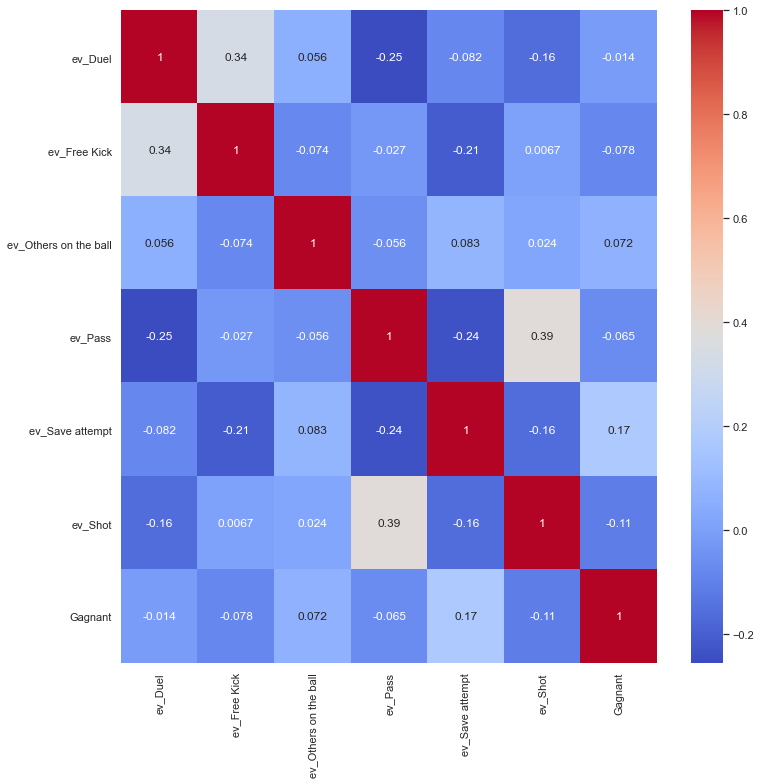

In [43]:
#Matrice de corrélation
import matplotlib.pyplot as plt
import seaborn as sns

cor = domi.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(cor, annot = True, ax = ax, cmap = "coolwarm");

In [44]:
#Suppression de la colonne name
domi = domi.drop("name",axis=1)

### Comparaison des méthodes

Afin de pouvoir établir nos différentes de méthodes de classification, nous allons séparé notre jeu de données en une partie d'entrainement et une partie test. On s'assurera que la partie test correspond aux matchs les plus récents. On spécifiera donc le paramètre 'shuffle = False' dans la fonction *train_test_split*.

In [45]:
#Séparation entre données d'entrainement et données test
from sklearn.model_selection import train_test_split
import numpy as np


data = domi.drop("Gagnant",axis=1)
target = domi.Gagnant

X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=False, test_size = 0.2)

On s'interesse maintenant aux classifieurs qui vont nous permettre de résoudre notre étude sur la prédiction des matchs. Nous allons comparer les classifieurs LinearSVC, RegressionLogistque, ElasticNet, AdaBoost et RandomForest étudiés durant la formation. D'autre part, à partir du site [scikit-learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), nous étudierons le classifieur Naive Bayes. Le but sera de comparer les scores (à partir du coefficient de détermination R2) et les erreurs quadratique moyenne de chaque modèle afin de choisir les meilleurs. 

**LinearSVC**

Les machines à vecteurs de support sont un ensemble de techniques d'apprentissage supervisé destinées à résoudre des problèmes de discrimination et de régression. Les SVM sont une généralisation des classifieurs linéaires. On s'interessera ici à l'un d'entre eux le LinearSVC. 

In [46]:
#Classification LinearSVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

svc = LinearRegression()
svc.fit(X_train,y_train)

LinearRegression()

In [47]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',svc.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',svc.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 0.04609396508856389
Le score du modèle sur l ensemble test est 0.022250337333241443


In [48]:
#Affichage des erreurs
from sklearn.metrics import mean_squared_error

svc_pred_train = svc.predict(X_train)
svc_pred_test = svc.predict(X_test)
print('La MSE de la partie train est:',mean_squared_error(svc_pred_train,y_train))
print('La MSE de la partie test est:',mean_squared_error(svc_pred_test,y_test))

La MSE de la partie train est: 0.22860822398893968
La MSE de la partie test est: 0.23181151609712924


In [49]:
# Calcul de la matrice de prediction
cm = pd.crosstab(y_test,svc_pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1.153341,1.185479,1.186816,1.187498,1.191683,1.200525,1.203886,1.205265,1.207179,1.210720,...,1.630111,1.658265,1.664634,1.677946,1.684765,1.699913,1.710825,1.717893,1.817766,1.829401
Classe réelle,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,0


**Naive Bayes**

Le Naive Bayes Classifier est un algorithme populaire en Machine Learning. C'est un algorythme du Supervised Learning utilisé pour la classification. Il est particulièrement utile pour les problématiques de classification de texte. Un exemple d'utilisation du Naive Bayes est celui du filtre anti-spam.

In [50]:
#Classification Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,y_train)

GaussianNB()

In [51]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',nb.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',nb.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 0.6216730038022814
Le score du modèle sur l ensemble test est 0.6060606060606061


In [52]:
#Affichage des erreurs
from sklearn.metrics import mean_squared_error
nb_pred_train = nb.predict(X_train)
nb_pred_test = nb.predict(X_test)
print('La MSE de la partie train est:',mean_squared_error(nb_pred_train,y_train))
print('La MSE de la partie test est:',mean_squared_error(nb_pred_test,y_test))

La MSE de la partie train est: 0.37832699619771865
La MSE de la partie test est: 0.3939393939393939


In [53]:
    # Calcul de la matrice de prediction
    cm = pd.crosstab(y_test,nb_pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
    cm

Classe prédite,1,2
Classe réelle,,
1,127,35
2,69,33


**Regression Logistique**

La regression logistique est un modèle de régression binomiale. Comme tous les modèles de régression binomiale, il s'agit de modéliser au mieux un modèle mathématique simple à partir des observations réelles nombreuses. En d'autres termes d'associer à un vecteur de variables aléatoires ( x 1 , … , x K ) à une variable aléatoire binomiale génériquement notée y. La régression logistique constitue un cas particulier de modèle linéaire généralisé. Elle est largement utilisée en apprentissage automatique.

In [54]:
#Classification à l'aide d'une régression logistique
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(C=1.0)
clf2.fit(X_train, y_train)

LogisticRegression()

In [55]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',clf2.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',clf2.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 0.6140684410646388
Le score du modèle sur l ensemble test est 0.6060606060606061


In [56]:
#Affichage des erreurs
clf2_pred_train = clf2.predict(X_train)
clf2_pred_test = clf2.predict(X_test)
print('La MSE de la partie train est:',mean_squared_error(clf2_pred_train,y_train))
print('La MSE de la partie test est:',mean_squared_error(clf2_pred_test,y_test))

La MSE de la partie train est: 0.38593155893536124
La MSE de la partie test est: 0.3939393939393939


In [57]:
# Calcul de la matrice de prediction
cm = pd.crosstab(y_test,clf2_pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1,2
Classe réelle,,
1,131,31
2,73,29


**Elastic Net**

La méthode Elastic Net est un type de régression régularisée pour laquelle le coefficient de pénalisation est une combinaison linéaire des pénalité L1 et L2. Il est donc un dérivé des régressions de Ridge et Lasso avec pour avantages: La conservation de la capacité de sélection de variables de LASSO avec exclusion des variables non pertinentes et le partage des poids entre variables corrélées et pas de sélection arbitraire.  

In [58]:
#Classification à l'aide d'une régression régularisée appelée Elastic Net
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV()
model_en.fit(X_train,y_train)

ElasticNetCV()

In [59]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',model_en.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',model_en.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 0.0460497043579533
Le score du modèle sur l ensemble test est 0.022942129729868865


In [60]:
#Affichage des erreurs
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)

print('La valeur RMSE du modèle d entrainement est:',mean_squared_error(pred_train,y_train))
print('La valeur RMSE du modèle test est:',mean_squared_error(pred_test,y_test))

La valeur RMSE du modèle d entrainement est: 0.2286188312884503
La valeur RMSE du modèle test est: 0.23164750126755693


In [61]:
# Calcul de la matrice de prediction
cm = pd.crosstab(y_test,pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1.161258,1.193498,1.193636,1.196869,1.197190,1.208753,1.209470,1.211546,1.214229,1.217283,...,1.625619,1.650938,1.657303,1.667257,1.677280,1.692279,1.701256,1.709784,1.808443,1.818333
Classe réelle,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,1,1,0


**Ada Boost**

Le Boosting est un ensemble de méthodes visant essentiellement à réduire le biais de modèles de Machine Learning simples et faibles et les convertir en un modèle stable et puissant. AdaBoost est un algorithme parmi tant d'autres dont l'idée consiste.  à appliquer cette règle plusieurs fois en affectant judicieusement un poids différent aux observations à chaque itération.
Les poids de chaque observation sont initialisés à 1/n pour l’estimation du premier modèle.Ils sont ensuite mis à jour pour chaque itération. L’importance d’une observation est inchangée si l’observation est bien classée; dans le cas contraire elle augmente avec la qualité d’ajustement du modèle mesurée.
L’agrégation finale est une combinaison des estimateurs obtenus pondérée par les qualités d’ajustement de chaque modèle.   

In [62]:
#Classification à l'aide de séquences d'arbre d'arbres de décisions ADABOOST 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ac = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=5))
ac.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5))

In [63]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',ac.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',ac.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 1.0
Le score du modèle sur l ensemble test est 0.4810606060606061


In [64]:
#Affichage des erreurs
ac_pred_train = ac.predict(X_train)
ac_pred_test = ac.predict(X_test)

print('La valeur RMSE du modèle d entrainement est:',mean_squared_error(ac_pred_train,y_train))
print('La valeur RMSE du modèle test est:',mean_squared_error(ac_pred_test,y_test))

La valeur RMSE du modèle d entrainement est: 0.0
La valeur RMSE du modèle test est: 0.5189393939393939


In [65]:
# Calcul de la matrice de prediction
cm = pd.crosstab(y_test,ac_pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1,2
Classe réelle,,
1,93,69
2,68,34


**Random Forest**

Les forêts arbres décisionnels sont des techniques d'apprentissage automatique. Cet algorithme combine les concepts des sous-espaces de bagging. L'algoritme des forêts décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [67]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',rf.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',rf.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 1.0
Le score du modèle sur l ensemble test est 0.5795454545454546


In [68]:
#Affichage des erreurs
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

print('La valeur RMSE du modèle d entrainement est:',mean_squared_error(rf_pred_train,y_train))
print('La valeur RMSE du modèle test est:',mean_squared_error(rf_pred_test,y_test))

La valeur RMSE du modèle d entrainement est: 0.0
La valeur RMSE du modèle test est: 0.42045454545454547


In [69]:
# Calcul de la matrice de prediction
cm = pd.crosstab(y_test,rf_pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1,2
Classe réelle,,
1,124,38
2,73,29


In [70]:
#On récapitule les scores et erreurs dans différents tableaux qui seront fusionnés en un seul.
en = pd.DataFrame((model_en.score(X_train,y_train),model_en.score(X_test,y_test),mean_squared_error(pred_train,y_train),mean_squared_error(pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['ElasticNet'])

lsvc = pd.DataFrame((svc.score(X_train,y_train),svc.score(X_test,y_test),mean_squared_error(svc_pred_train,y_train),mean_squared_error(svc_pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['Linear SVC'])

lr = pd.DataFrame((clf2.score(X_train,y_train),clf2.score(X_test,y_test),mean_squared_error(clf2_pred_train,y_train),mean_squared_error(clf2_pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['Logistic Regression'])

nba = pd.DataFrame((nb.score(X_train,y_train),nb.score(X_test,y_test),mean_squared_error(nb_pred_train,y_train),mean_squared_error(nb_pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['Naive Bayes'])

lac = pd.DataFrame((ac.score(X_train,y_train),ac.score(X_test,y_test),mean_squared_error(ac_pred_train,y_train),mean_squared_error(ac_pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['AdaBoost'])

lrf = pd.DataFrame((rf.score(X_train,y_train),rf.score(X_test,y_test),mean_squared_error(rf_pred_train,y_train),mean_squared_error(rf_pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['Random Forest'])

tab = pd.concat([en,lsvc,lr,nba,lac,lrf],axis=1)
tab

,ElasticNet,Linear SVC,Logistic Regression,Naive Bayes,AdaBoost,Random Forest
score entrainement,0.046050,0.046094,0.614068,0.621673,1.000000,1.000000
score test,0.022942,0.022250,0.606061,0.606061,0.481061,0.579545
MSE entrainement,0.228619,0.228608,0.385932,0.378327,0.000000,0.000000
MSE test,0.231648,0.231812,0.393939,0.393939,0.518939,0.420455


On constate que parmi les modèles testés, les modèles LogisticRegression, Naive Bayes, AdaBoost et Random Forest obtiennent les meilleurs résultats. Nous allons donc maintenant tester différents paramètres parmi ces modèles afin de sélectionner le meilleur pour la suite de notre étude.

In [71]:
lrf = pd.DataFrame((rf.score(X_train,y_train),rf.score(X_test,y_test),mean_squared_error(rf_pred_train,y_train),mean_squared_error(rf_pred_test,y_test)) , 
             index =['score entrainement', 'score test','MSE entrainement', 'MSE test'], columns = ['Random Forest'])

### Sélection du modèle

Dans cette partie, nous allons sélectionner un modèle grâce la validation croisée imbriquée (nested cross validation). En effet, celà va nous permettre de choisir nos hyperparamètres et d'estimer de manière la plus fiable possible l'erreur de généralisation de chaque modèle. 

In [72]:
#Instanciation de 2 grilles contenant les paramètres à tester de nos modèles
#On fixera le maximum d'iteration à 2000 et on fixe random_state à 22
clf2_bt = LogisticRegression(random_state=22,max_iter=2000)

nb_bt = GaussianNB()

param_grid_nb = {'var_smoothing': [1e-9,2e-9]}

param_grid_lr  = {'solver': ['liblinear', 'lbfgs'],
                  'C': np.logspace(-4,2,9)}

param_grid_ac = {'n_estimators':[50,500,1000]}

param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                  'min_samples_leaf': [1, 3, 5],
                  'max_features': ['sqrt', 'log2']}]

In [73]:
#Instanciation d'une grille qui contient les modèles et les paramètres correspondants
from sklearn.model_selection import GridSearchCV, cross_val_score
gridcvs ={}

for pgrid, clf, name in zip((param_grid_nb,param_grid_lr,param_grid_ac,param_grid_rf),(nb_bt,clf2_bt,ac,rf),('Naive Bayes','LogisticRegression','AdaBoost','Random Forest')):
    gcv = GridSearchCV(clf,pgrid,cv=3,refit=True)
    gridcvs[name] = gcv

In [74]:
#Calcul des scores par validation croisée
from sklearn.model_selection import StratifiedKFold

outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, 
                                   X_train, 
                                   y_train, 
                                   cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

Naive Bayes: outer accuracy 61.03 +/- 0.49
LogisticRegression: outer accuracy 61.03 +/- 1.10
AdaBoost: outer accuracy 58.27 +/- 3.16
Random Forest: outer accuracy 60.74 +/- 1.45


In [75]:
print(gridcvs)

{'Naive Bayes': GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 2e-09]}), 'LogisticRegression': GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=2000, random_state=22),
             param_grid={'C': array([1.00000000e-04, 5.62341325e-04, 3.16227766e-03, 1.77827941e-02,
       1.00000000e-01, 5.62341325e-01, 3.16227766e+00, 1.77827941e+01,
       1.00000000e+02]),
                         'solver': ['liblinear', 'lbfgs']}), 'AdaBoost': GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5)),
             param_grid={'n_estimators': [50, 500, 1000]}), 'Random Forest': GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 3, 5],
                          'n_estimators': [10, 50, 100, 250, 500, 1000]}])}


Les scores par validation croisée étant sérrés, on prend soin d'afficher pour chacun la sélection d'hyperparamètres les plus optimisés.

In [76]:
#Affichage des paramètres sélectionnés 
#et affichage taux de bonnes prédictions du modèle sur l'ensemble d'entraînement et l'ensemble de test
from sklearn.metrics import accuracy_score

final_clf = gridcvs['LogisticRegression']
final_clf.fit(X_train, y_train)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Training Accuracy: 61.41
Test Accuracy: 60.61


In [77]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['Naive Bayes']
final_clf.fit(X_train, y_train)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'var_smoothing': 1e-09}
Training Accuracy: 62.17
Test Accuracy: 60.61


In [78]:
from sklearn.metrics import accuracy_score

final_clf = gridcvs['Random Forest']
final_clf.fit(X_train, y_train)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}
Training Accuracy: 86.03
Test Accuracy: 58.33


Le modèle sélectionné est le modèle Logistic Regression qui obtient les meilleurs résultats. 
Dans la suite de l'étude, on s'accordera à utiliser ce modèle pour faire nos prédictions à partir de la variable 'action'.

## 2-3. Prédictions finales <a class="anchor" id="section_2_3"></a>

Il est important de rappeler que notre jeu de données ne comporte ni les matchs nuls ni les côtes des Bookmakers.

De la même façon que  le dataframe "domi", nous avons créé en parallèle "domi2". En effet, ce dataframe est beaucoup plus précis que le précédent car il apporte plus de précisions sur le évènements de jeu.

In [79]:
domi2 = pd.read_csv('Match_actions.csv')
domi2.head()

,Unnamed: 0,match_id,dateutc,competition,season,venue,home_club,away_club,winner,goal_by_home_club,...,act_High pass,act_Launch,act_Penalty,act_Reflexes,act_Save attempt,act_Shot,act_Simple pass,act_Smart pass,act_Throw in,name
0,0,0,2018-05-20 18:45:00,Italian first division,2018,"""""",Lazio,Internazionale,Internazionale,2,...,11,16,0,3,1,4,189,3,22,Lazio
1,1,30,2018-04-29 18:45:00,Italian first division,2018,"""""",Torino,Lazio,Lazio,0,...,22,6,0,1,1,6,287,5,17,Lazio
2,2,44,2018-04-22 13:00:00,Italian first division,2018,"""""",Lazio,Sampdoria,Lazio,4,...,22,12,0,0,1,10,267,2,10,Lazio
3,3,54,2018-04-18 18:45:00,Italian first division,2018,"""""",Fiorentina,Lazio,Lazio,3,...,10,4,0,1,1,7,325,5,28,Lazio
4,4,71,2018-04-08 16:00:00,Italian first division,2018,"""""",Udinese,Lazio,Lazio,1,...,17,4,0,1,1,4,486,6,25,Lazio


In [80]:
#Filtre sur les gagnants
domi2=domi2[domi2.winner == domi2.name]

#Trie des dates par ordre croissant
cols=['dateutc', 'match_id']
domi2 = domi2.sort_values(by=cols)

#Suppression des colonnes inutiles à l'étude
domi2 = domi2.drop(['dateutc','season','venue','goal_by_home_club','goal_by_away_club','referee_id','match_id','competition','home_club','away_club','club_id'],axis=1)

#Création d'une colonne Gagnant quand l'équipe à domicile gagne
domi2['Gagnant'] = domi2.apply(lambda x: 1 if x['dom_game'] == 1 else 2, axis = 1)

#On effectue un reset de l'index de l'index
domi2=domi2.reset_index(drop = True)

In [81]:
#Réorganisation du dataset domi
domi2 = domi2[['name','act_Acceleration','act_Corner', 'act_Cross',
       'act_Free Kick', 'act_Free kick cross', 'act_Free kick shot',
       'act_Ground attacking duel', 'act_Ground defending duel',
       'act_Ground loose ball duel', 'act_Hand pass', 'act_Head pass',
       'act_High pass', 'act_Launch', 'act_Penalty', 'act_Reflexes',
       'act_Save attempt', 'act_Shot', 'act_Simple pass', 'act_Smart pass',
       'act_Throw in', 'Gagnant']]

In [82]:
domi2.head()

,name,act_Acceleration,act_Corner,act_Cross,act_Free Kick,act_Free kick cross,act_Free kick shot,act_Ground attacking duel,act_Ground defending duel,act_Ground loose ball duel,...,act_High pass,act_Launch,act_Penalty,act_Reflexes,act_Save attempt,act_Shot,act_Simple pass,act_Smart pass,act_Throw in,Gagnant
0,Monaco,1,7,6,13,5,1,62,29,16,...,21,3,0,1,1,5,335,10,22,1
1,PSG,1,6,4,5,0,0,49,46,17,...,15,0,0,0,1,5,594,15,21,1
2,Olympique Lyonnais,1,2,4,10,1,1,56,26,12,...,10,1,1,1,0,5,410,4,20,1
3,Guingamp,1,1,8,2,0,0,40,31,18,...,8,6,1,1,1,4,285,2,14,2
4,Montpellier,1,7,6,9,1,0,64,37,16,...,18,6,0,0,1,2,265,5,23,1


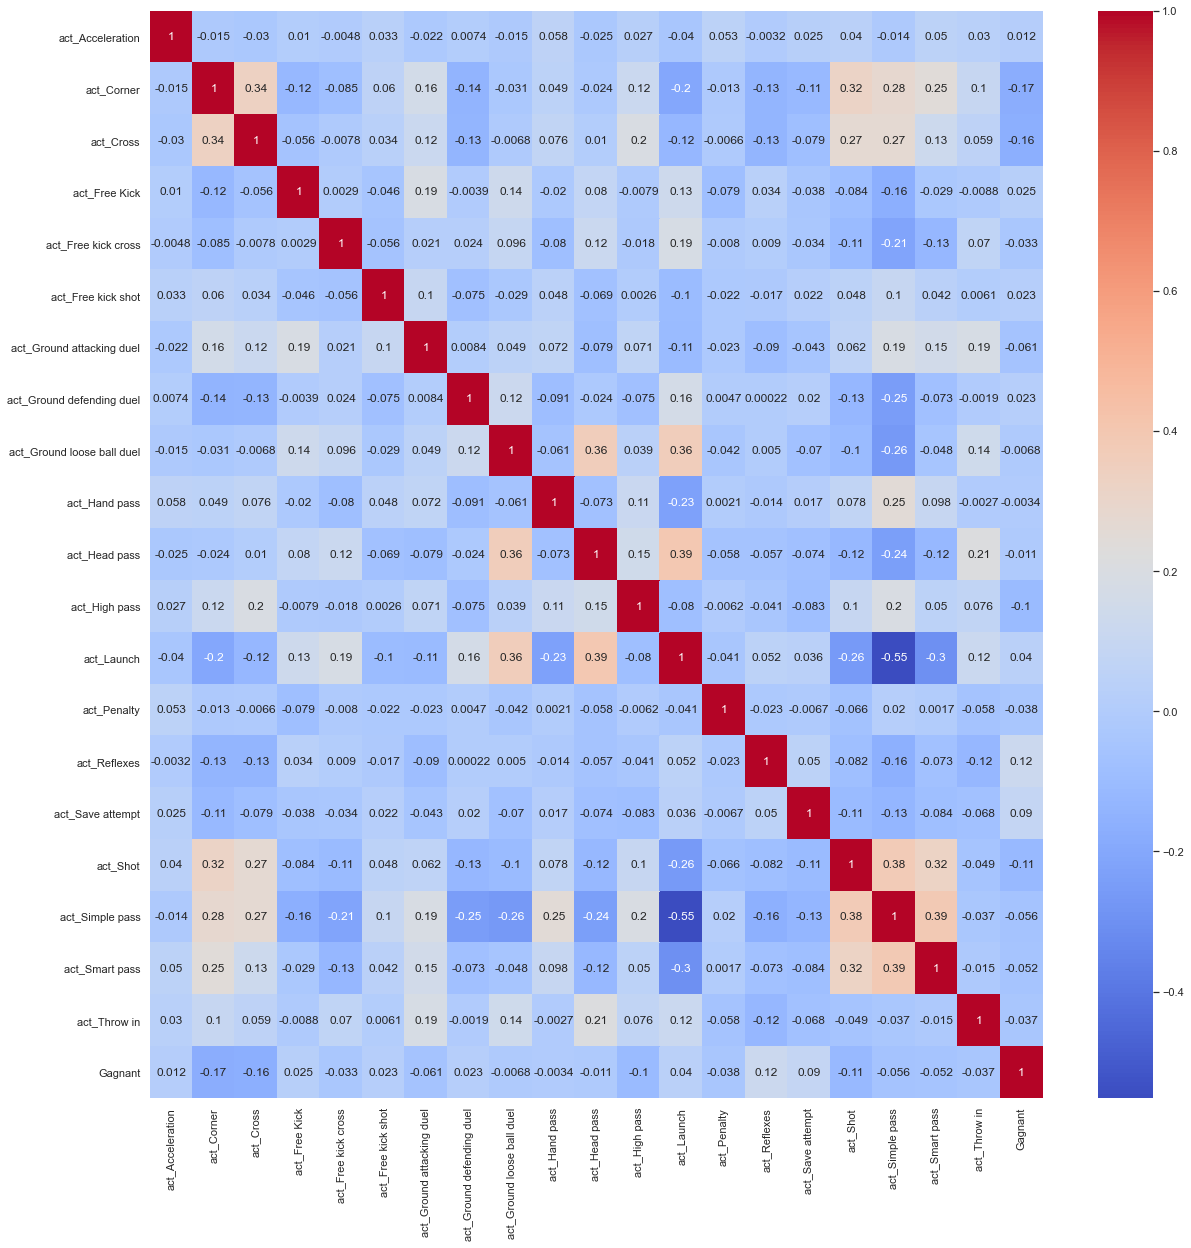

In [83]:
#Affichage du tableau de corrélation
cor = domi2.corr()
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cor, annot = True, ax = ax, cmap = "coolwarm");

In [84]:
#Suppression de la colonne name
domi2 = domi2.drop("name",axis=1)

In [85]:
#Séparation entre données d'entrainement et données test
data = domi2.drop("Gagnant",axis=1)
target = domi2.Gagnant

X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=False, test_size = 0.2)

On effectue maintenant une classification de notre jeu de données grâce à l'algorithme de Regression Logistic que nous avions choisi plut haut. En effet, nous savons que ce type de classifieur est optimisé pour notre étude. On y associera également les hyperparamètres que l'algorithme de validation croisée imbriquée a déterminé.  

In [94]:
#Classification à partir du classifieur logistic Regression avec les hyperparamètres optimaux
clf3 = LogisticRegression(C = 0.1, random_state=22,max_iter=2000)
clf3.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=2000, random_state=22)

In [95]:
#Affichage des scores
print('Le score du modèle sur l ensemble d apprentissage est',clf3.score(X_train,y_train))
print('Le score du modèle sur l ensemble test est',clf3.score(X_test,y_test))

Le score du modèle sur l ensemble d apprentissage est 0.6380597014925373
Le score du modèle sur l ensemble test est 0.6380597014925373


In [89]:
#Affichage des erreurs
clf3_pred_train = clf3.predict(X_train)
clf3_pred_test = clf3.predict(X_test)
print('La MSE de la partie train est:',mean_squared_error(clf3_pred_train,y_train))
print('La MSE de la partie test est:',mean_squared_error(clf3_pred_test,y_test))

La MSE de la partie train est: 0.3619402985074627
La MSE de la partie test est: 0.3619402985074627


In [90]:
#Calcul de la matrice de prediction
cm = pd.crosstab(y_test,clf3_pred_test , rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,1,2
Classe réelle,,
1,134,30
2,67,37


Le score obtenu pour la partie test est de 63,8%. On s'interresse maintenant au pourcentage de victoires qu'a accordé notre algorithme sur chacune des équipes. Le tableau suivant récapitule le taux de prédiction de chaque équipe sur la victoire et fait le comparatif entre la prédiction et la réalité.

In [91]:
#Création de DataFrames pour les prédictions
dt = pd.DataFrame(clf3.predict_proba(X_test),index = range(1072,1340),columns=["Equipe à domicile","Equipe à l'exterieure"])
c3 = pd.DataFrame(clf3_pred_test,index = range(1072,1340),columns = ["Prédiction"])
c4 = pd.DataFrame(y_test)

final = pd.concat([dt,c3,c4],axis=1)
final = final.rename(columns ={"Gagnant":"Réalité"})
final.head()

,Equipe à domicile,Equipe à l'exterieure,Prédiction,Réalité
1072,0.442758,0.557242,2,2
1073,0.527037,0.472963,1,2
1074,0.731625,0.268375,1,1
1075,0.552797,0.447203,1,1
1076,0.526461,0.473539,1,1


On constate par exemple que pour le second match la prediction est sérrée (53% pour l'équipe à domicile et 47% pour l'équipe à l'extérieur) et est finalement fausse. En effet, notre modèle n'est pas parfait et fait des erreurs. On affichera les bonnes prédictions et les mauvaises prédictions pour savoir comment notre modèle fonctionne en détail selon qu'une équipe soit à domicile ou à l'extérieur. 

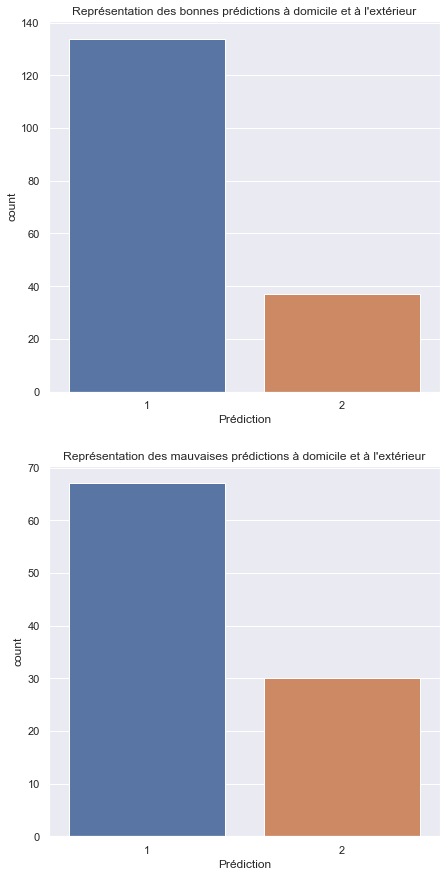

In [92]:
plt.figure(figsize=(7,15))

plt.subplot(211)
X = final[final.Prédiction == final.Réalité]
sns.countplot(x="Prédiction",data=X);
plt.title("Représentation des bonnes prédictions à domicile et à l'extérieur");

plt.subplot(212)
X2 = final[final.Prédiction != final.Réalité]
sns.countplot(x="Prédiction",data=X2);
plt.title("Représentation des mauvaises prédictions à domicile et à l'extérieur");

On constate que notre modèle a un taux de réussite plus important pour les équipes qui jouent à domiciles car en effet, comme vu plus haut, une équipe a 60,3% de chance de remporter un match sur son terrain. Il aura donc tendance à prédire plus facilement la victoire pour les équipes qui jouent à domicile. Il en est de même pour les mauvaises prédictions.    

# Conclusion <a class="anchor" id="chapter3"></a>

Dans cette étude, nous avons prouvé qu'à partir des données mises à notre disposition, on peut extraire les informations utiles pour prédire les résultats d'un match. Les méthodes de Machine Learning que l'on a vu durant cette formation ainsi que les méthodes d'optimisations ont permis d'obtenir l'ensemble des résultats de prédiction. Il existe de nombreuses méthodes comme la célèbre méthode de la loi de poisson ou la méthode de Pearson ([Cf.lien suivant](https://towardsdatascience.com/making-big-bucks-with-a-data-driven-sports-betting-strategy-6c21a6869171)). Malgré des informations capitales maquantes comme les matchs nuls et leurs scores, nous avons réussi à avoir un meilleur taux  de prédiction que Pearson, c'est-à-dire **63,8% sur 268 matchs** contre 54.9% sur 273 matchs. On s'approche égalment du taux de bonnes prédictions de l'auteur de l'article précédent à savoir 64,1%. Par ailleurs, il nous manquait aussi les côtes des bookmakers qui auraient pu nous premettre de nous comparer à eux. Nous avons donc réussi notre objectif à savoir de prédire du mieux possible les vainqueurs de match de football sur l'année 2017/2018 avec une précision semblable à des modèles existants.